# Linear Auto Encoder

Using Python and Numpy, write a class named LinearAutoEncoder with necessary methods, which implements a linear autoencoder. 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
class LinearAutoEncoder:
    def __init__(self, hiddenSize, learningRate, max_loop, lambda_):
        # Initialization of the MLP model with given parameters
        self.hiddenNum = len(hiddenSize)
        self.hiddenSize = hiddenSize
        self.learningRate = learningRate
        self.max_loop = max_loop
        self.X = None
        self.Y = None
        self.w = None
        self.v = None
        self.hidw = None
        self.y_pred = None
        self.lambda_ = lambda_
    
    def sigmoid(self, z):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-z))
    
    def ReLu(self, x):
        # Rectified Linear Unit (ReLU) activation function
        temp = x <= 0
        x[temp] = 0
        return x
    
    def relu_derivative(self, y):
        # Derivative of ReLU activation function
        return np.where(y > 0, 1.0, 0.0)

    def preprocess(self, X, Y):
        # Preprocessing of input data
        np.random.seed(1)
        X = np.insert(X, 0, 1, axis=1)
        self.X = X
        self.Y = Y
        # He initialization for the first hidden layer
        # self.v = np.random.randn(self.hiddenSize[0], self.X.shape[1] - 1) * np.sqrt(2. / (self.X.shape[1] - 1))
        self.v= np.random.rand(self.hiddenSize[0], self.X.shape[1] - 1)
        self.v = np.insert(self.v, 0, 0, axis=1)
        # Xavier initialization for the outer layer
        self.w = np.random.rand(self.Y.shape[1], self.hiddenSize[-1])
        self.w = np.insert(self.w, 0, 0, axis=1)
        self.hidw = []
        # He initialization for subsequent hidden layers
        for i in range(1, self.hiddenNum):
            # hw = np.random.randn(self.hiddenSize[i], self.hiddenSize[i - 1]) * np.sqrt(2. / (self.hiddenSize[i - 1]))
            hw=np.random.rand(self.hiddenSize[i], self.hiddenSize[i - 1])
            hw = np.insert(hw, 0, 0, axis=1)
            self.hidw.append(hw)
            
    def forward(self):
        # Forward propagation through the MLP
        self.h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h = self.ReLu(np.dot(self.X, self.v.T))
                self.h.append(h)
            else:
                h = self.ReLu(np.dot(np.insert(self.h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T))
                self.h.append(h)
        self.y_pred = np.dot(np.insert(self.h[-1], 0, 1, axis=1), self.w.T)
        
    def loss(self):
        # Calculate the loss function
        total_err= np.sum(np.square(self.y_pred - self.Y)) / 2
        return total_err
    
    def gradient(self):
        # Compute the gradients for backpropagation
        err = self.y_pred - self.Y
        self.grad_w = np.dot(np.insert(self.h[-1], 0, 1, axis=1).T, err).T
        self.grad_hidw = []
        if self.hiddenNum == 1:
            grad_h = np.dot(err , self.w[:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
        else:
            for i in range(self.hiddenNum - 1, 0, -1):
                if i == self.hiddenNum - 1:
                    grad_h = np.dot(err, self.w[:, 1:])
                else:
                    grad_h = np.dot(grad_h_0, self.hidw[i][:, 1:])
                grad_z = self.relu_derivative(self.h[i])
                grad_hidw = np.dot(np.insert(self.h[i - 1], 0, 1, axis=1).T, grad_h * grad_z).T
                self.grad_hidw.append(grad_hidw)
                grad_h_0 = grad_h
            grad_h = np.dot(grad_h_0, self.hidw[0][:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
            
    def train(self):
        # Training the MLP using gradient descent
        mse_values = []  # List to store MSE values for each iteration
        for _ in range(self.max_loop + 1):
            self.forward()
            self.gradient()
            self.w = self.w - self.learningRate * self.grad_w
            for i in range(len(self.hidw)):
                self.hidw[i] = self.hidw[i] - self.learningRate * self.grad_hidw[-1 - i]
            self.v = self.v - self.learningRate * self.grad_v
            if _ % 1 == 0:
                print("Epoch: ", _, " MSE: ", self.loss())
                mse = self.loss()
                mse_values.append(mse)
        plt.plot(range(0, self.max_loop + 1, 1), mse_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        title = 'Epoch-MSE Graph, learning rate = ' + str(self.learningRate) + r', $\alpha$=' + str(self.lambda_)
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    def predict(self, X):
        # Make predictions using the trained model
        X = np.insert(X, 0, 1, axis=1)
        h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h.append(self.ReLu(np.dot(X, self.v.T)))
            else:
                h.append(self.ReLu(np.dot(np.insert(h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T)))
        y_pred = np.dot(np.insert(h[-1], 0, 1, axis=1), self.w.T)
        return y_pred

Epoch:  0  MSE:  4.96969037934718e+19
Epoch:  1  MSE:  3.1806040842589676e+19
Epoch:  2  MSE:  1.2722416337035863e+18
Epoch:  3  MSE:  5.088966534814343e+16
Epoch:  4  MSE:  2035586613925736.5
Epoch:  5  MSE:  81423464557029.44
Epoch:  6  MSE:  3256938582281.176
Epoch:  7  MSE:  130277543291.24698
Epoch:  8  MSE:  5211101731.649878
Epoch:  9  MSE:  208444069.26599497
Epoch:  10  MSE:  8337762.770639796
Epoch:  11  MSE:  333510.51082559174
Epoch:  12  MSE:  13340.42043302366
Epoch:  13  MSE:  533.6168173209464
Epoch:  14  MSE:  21.344672692837843
Epoch:  15  MSE:  0.853786907713497
Epoch:  16  MSE:  0.03415147630853925
Epoch:  17  MSE:  0.0013660590523416607
Epoch:  18  MSE:  5.464236209368267e-05
Epoch:  19  MSE:  2.185694483751047e-06
Epoch:  20  MSE:  8.742777934981536e-08
Epoch:  21  MSE:  3.497111174157308e-09
Epoch:  22  MSE:  1.3988444699773952e-10
Epoch:  23  MSE:  5.595377872646164e-12
Epoch:  24  MSE:  2.2381510932655577e-13
Epoch:  25  MSE:  8.95260496054327e-15
Epoch:  26  M

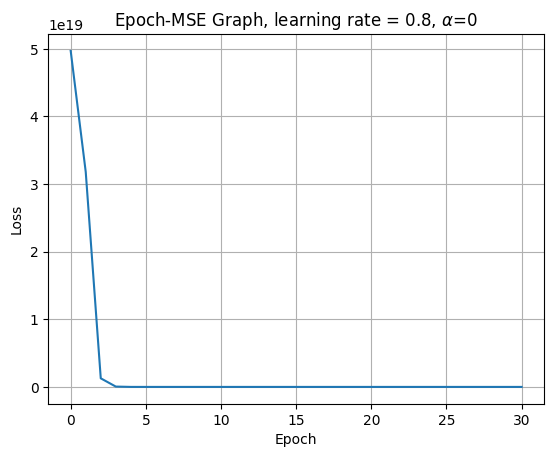

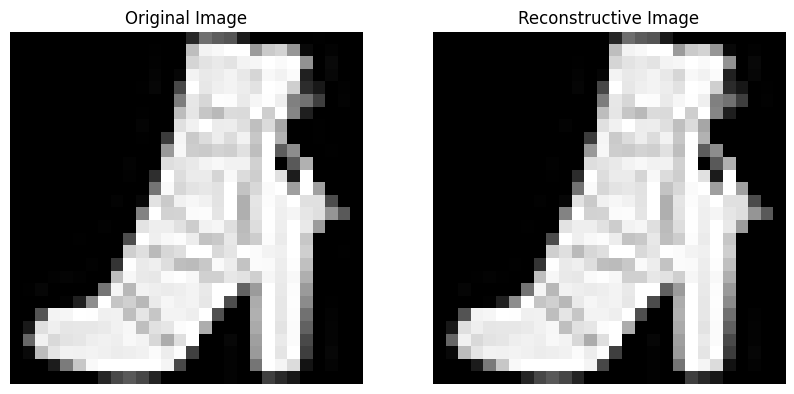

In [67]:
from PIL import Image
import matplotlib.pyplot as plt
sample_image=Image.open('test_image1.png')
sample_image=np.array(sample_image)
x=np.array([sample_image.ravel()])
model0=LinearAutoEncoder([50,30,50], 0.8, 30, 0)
model0.preprocess(x, x)
model0.train()
# Reconstruction
x_new=model0.h[1]
h = []
h.append(model0.ReLu(np.dot(np.insert(x_new,0,1,axis=1), model0.hidw[1].T)))
y_pred = np.dot(np.insert(h[-1], 0, 1, axis=1), model0.w.T)
y_pred=y_pred.astype(int)
y_pred=y_pred.reshape(sample_image.shape)
_, axes = plt.subplots(1, 2, figsize=(10, 5))
# Show the images
axes[0].imshow(sample_image,cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(y_pred,cmap='gray')
axes[1].axis('off')
axes[1].set_title('Reconstructive Image')
plt.show()

Epoch:  0  MSE:  1.4690821467799245e+19
Epoch:  1  MSE:  9.402155272541737e+18
Epoch:  2  MSE:  3.760862109016694e+17
Epoch:  3  MSE:  1.5043448436066766e+16
Epoch:  4  MSE:  601737937442670.5
Epoch:  5  MSE:  24069517497706.805
Epoch:  6  MSE:  962780699908.2719
Epoch:  7  MSE:  38511227996.33086
Epoch:  8  MSE:  1540449119.8532336
Epoch:  9  MSE:  61617964.79412932
Epoch:  10  MSE:  2464718.5917651714
Epoch:  11  MSE:  98588.74367060683
Epoch:  12  MSE:  3943.5497468242725
Epoch:  13  MSE:  157.7419898729711
Epoch:  14  MSE:  6.309679594918853
Epoch:  15  MSE:  0.2523871837967496
Epoch:  16  MSE:  0.010095487351869659
Epoch:  17  MSE:  0.0004038194940750126
Epoch:  18  MSE:  1.615277976302294e-05
Epoch:  19  MSE:  6.461111905204253e-07
Epoch:  20  MSE:  2.5844447618722777e-08
Epoch:  21  MSE:  1.0337779050142583e-09
Epoch:  22  MSE:  4.135111617308592e-11
Epoch:  23  MSE:  1.6540446470998433e-12
Epoch:  24  MSE:  6.61617909809802e-14
Epoch:  25  MSE:  2.6464712615227125e-15
Epoch:  2

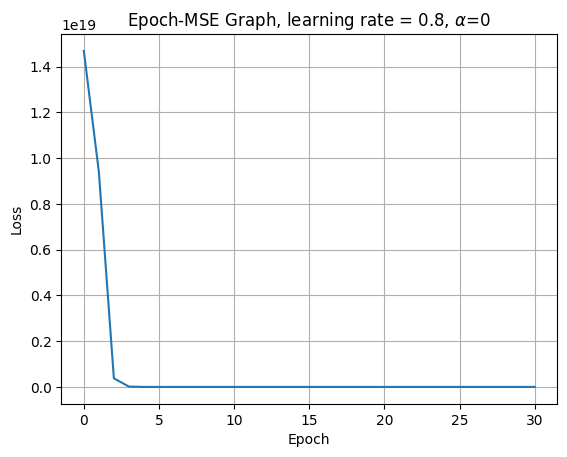

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


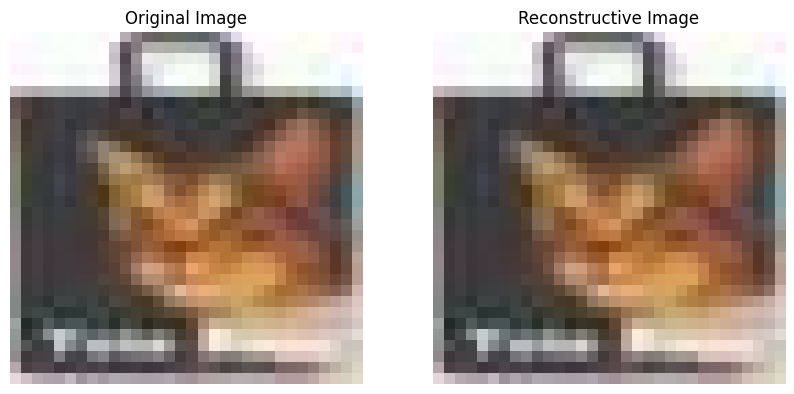

In [82]:
from PIL import Image
import matplotlib.pyplot as plt

sample_image=Image.open('test_image3.jpg')
sample_image=np.array(sample_image)
x=np.array([sample_image.ravel()])
model2=LinearAutoEncoder([20,10,20], 0.8, 30, 0)
model2.preprocess(x, x)
model2.train()
# Reconstruction
x_new=model2.h[1]
print(x_new)
# print('compressed image : ',x_new)
h = []
h.append(model2.ReLu(np.dot(np.insert(x_new,0,1,axis=1), model2.hidw[1].T)))
y_pred = np.dot(np.insert(h[-1], 0, 1, axis=1), model2.w.T)
y_pred=y_pred.astype(int)
y_pred=y_pred.reshape(sample_image.shape)
_, axes = plt.subplots(1, 2, figsize=(10, 5))
# Show the images
axes[0].imshow(sample_image,cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(y_pred,cmap='gray')
axes[1].axis('off')
axes[1].set_title('Reconstructive Image')
plt.show()
